# ARMA(1,1) Noise Model for Pastas
*R.A. Collenteur, University of Graz, May 2020*

In this notebook an Autoregressive-Moving-Average (ARMA(1,1)) noise model is developed for Pastas models. This new noise model is tested against synthetic data generated with NumPy or Statsmodels' ARMA model. This noise model is tested on head time series with a regular time step.

<div class="alert alert-info">
    
<b>Warning</b>

It should be noted that the time step may be non-equidistant in this formulation, but this model is not yet tested for irregular time steps.
   
</div>



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammainc, gammaincinv

import pastas as ps

ps.set_log_level("ERROR")
ps.show_versions()

Python version: 3.10.12
NumPy version: 1.26.4
Pandas version: 2.2.0
SciPy version: 1.12.0
Matplotlib version: 3.8.3
Numba version: 0.59.0
LMfit version: 1.2.2
Latexify version: 0.4.2
Pastas version: 1.5.0b


## 1. Develop the ARMA(1,1) Noise Model for Pastas

The following formula is used to calculate the noise according to the ARMA(1,1) process:

$$\upsilon(t_i) = r(t_i) - r(t_{i-1}) \text{e}^{-\Delta t_i / \alpha} - \upsilon(t_{i-1}) \text{e}^{-\Delta t_i / \beta}$$

where $\upsilon$ is the noise, $\Delta t_i$ the time step between the residuals ($r$), and respectively $\alpha$ [days] and $\beta$ [days] the parameters of the AR and MA parts of the model. The model is named `ArmaNoiseModel` and can be found in `noisemodel.py`. It is added to a Pastas model as follows: `ml.add_noisemodel(ps.ArmaNoiseModel())`

## 2. Generate synthetic head time series

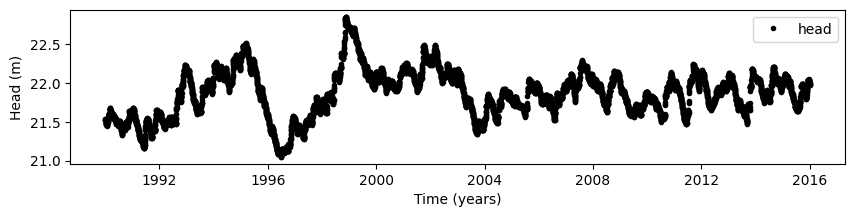

In [2]:
# Read in some data
rain = (
    pd.read_csv("../examples/data/rain_260.csv", index_col=0, parse_dates=[0]).squeeze()
    / 1000
)

# Set the True parameters
Atrue = 800
ntrue = 1.1
atrue = 200
dtrue = 20

# Generate the head
step = ps.Gamma().block([Atrue, ntrue, atrue])
h = dtrue * np.ones(len(rain) + step.size)
for i in range(len(rain)):
    h[i : i + step.size] += rain[i] * step
head = pd.DataFrame(
    index=rain.index,
    data=h[: len(rain)],
)
head = head["1990":"2015"]

# Plot the head without noise
plt.figure(figsize=(10, 2))
plt.plot(head, "k.", label="head")
plt.legend(loc=0)
plt.ylabel("Head (m)")
plt.xlabel("Time (years)");

## 3. Generate ARMA(1,1) noise and add it to the synthetic heads
In the following code-block, noise is generated using an ARMA(1,1) process using NumPy. An alternative procedure is available from Statsmodels (commented out now). More information about the ARMA model can be found on the [statsmodels website](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.ArmaProcess.html). The noise is added to the head series generated in the previous code-block.

In [3]:
# reproduction of random numbers
np.random.seed(1234)
alpha = 0.95
beta = 0.1

# generate samples using Statsmodels
# import statsmodels.api as stats
# ar = np.array([1, -alpha])
# ma = np.r_[1, beta]
# arma = stats.tsa.ArmaProcess(ar, ma)
# noise = arma.generate_sample(head[0].index.size)*np.std(head.values) * 0.1

# generate samples using NumPy
random_seed = np.random.RandomState(1234)

noise = random_seed.normal(0, 1, len(head)) * np.std(head.values) * 0.1
a = np.zeros_like(head[0])

for i in range(1, noise.size):
    a[i] = noise[i] + noise[i - 1] * beta + a[i - 1] * alpha

head_noise = head[0] + a

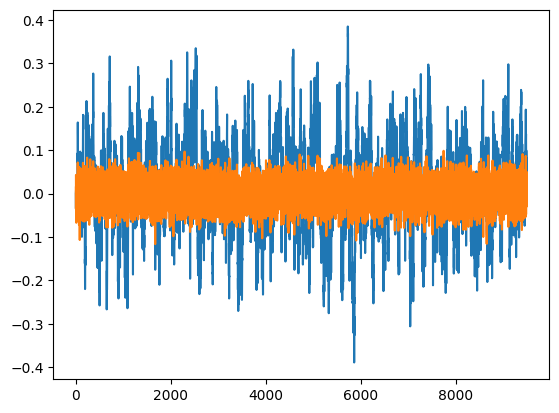

In [4]:
plt.plot(a)
plt.plot(noise)

## 4. Create and solve a Pastas Model

Fit report 0                       Fit Statistics
nfev    29                     EVP          88.33
nobs    8946                   R2            0.88
noise   True                   RMSE          0.11
tmin    1991-01-01 00:00:00    AIC      -62720.73
tmax    2015-06-29 00:00:00    BIC      -62678.14
freq    D                      Obj           4.03
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (6 optimized)
                optimal     initial  vary  stderr
recharge_A   734.086018  217.313623  True  ±3.17%
recharge_n     1.089086    1.000000  True  ±0.88%
recharge_a   191.477259   10.000000  True  ±4.99%
constant_d    20.177978   21.873653  True  ±0.27%
noise_alpha   20.575383    1.000000  True  ±7.18%
noise_beta     0.433754    1.000000  True  ±4.63%


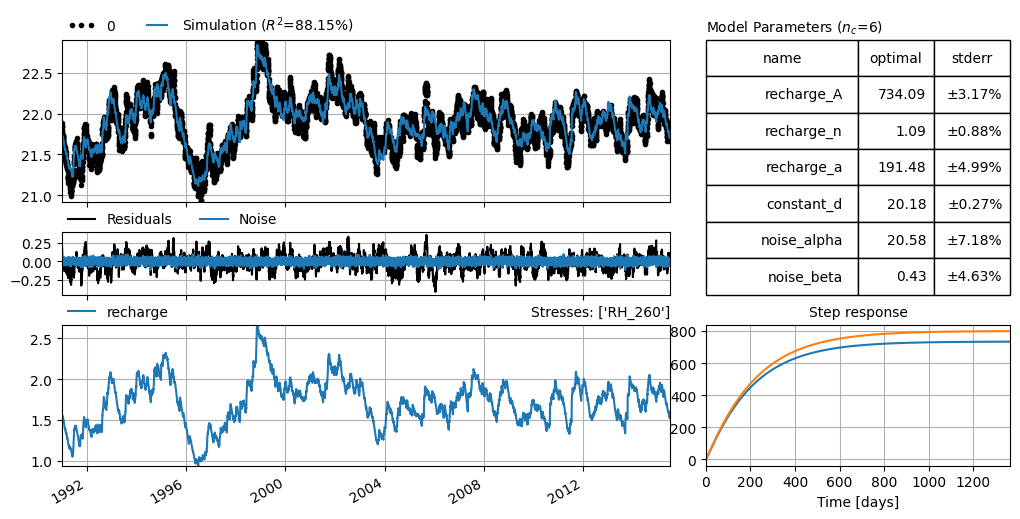

In [5]:
ml = ps.Model(head_noise)
sm = ps.StressModel(rain, ps.Gamma(), name="recharge", settings="prec")
ml.add_stressmodel(sm)
ml.add_noisemodel(ps.ArmaNoiseModel())

ml.solve(tmin="1991", tmax="2015-06-29", report=True)
axes = ml.plots.results(figsize=(10, 5))
axes[-2].plot(ps.Gamma().step([Atrue, ntrue, atrue]))

## 5. Did we find back the original ARMA parameters?

In [6]:
print(np.exp(-1.0 / ml.parameters.loc["noise_alpha", "optimal"]).round(2), "vs", alpha)
print(
    np.exp(-1.0 / np.abs(ml.parameters.loc["noise_beta", "optimal"])).round(2),
    "vs.",
    beta,
)

0.95 vs 0.95
0.1 vs. 0.1


The estimated parameters for the noise model are almost the same as the true parameters, showing that the model works for regular time steps.

## 6. So is the autocorrelation removed correctly?

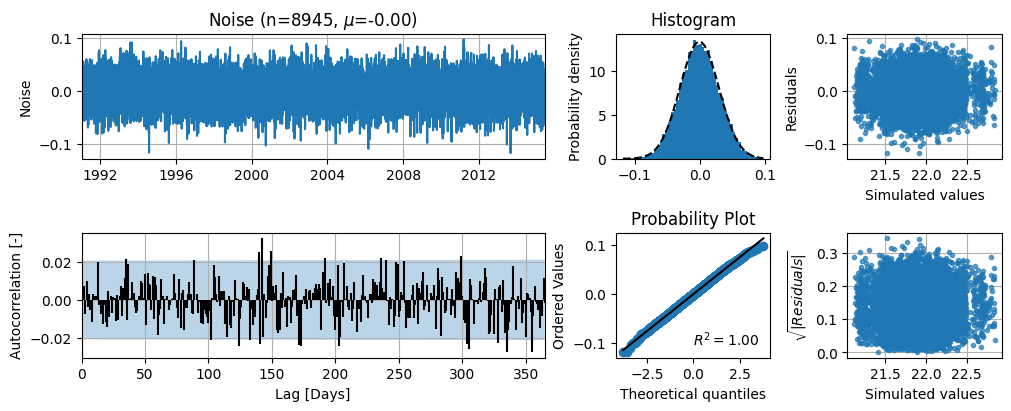

In [7]:
ml.plots.diagnostics(figsize=(10, 4));

That seems okay. It is important to understand that this noisemodel will only help in removing autocorrelations at the first time lag, but not at larger time lags, compared to its AR(1) counterpart. 

## 7. What happens if we use an AR(1) model?

0.96 vs 0.95


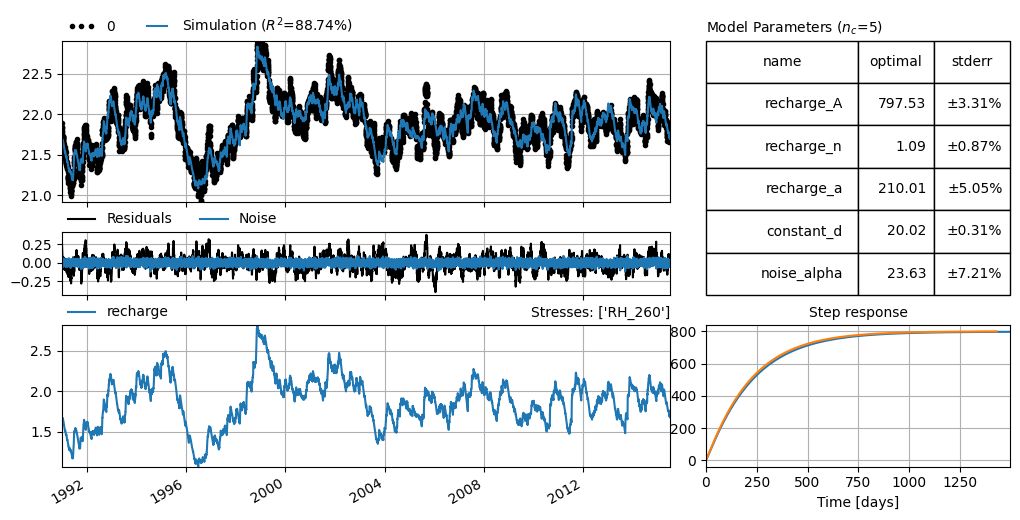

In [8]:
ml = ps.Model(head_noise)
ml.add_noisemodel(ps.ArNoiseModel())
sm = ps.StressModel(rain, ps.Gamma(), name="recharge", settings="prec")
ml.add_stressmodel(sm)

ml.solve(tmin="1991", tmax="2015-06-29", report=False)
axes = ml.plots.results(figsize=(10, 5))
axes[-2].plot(ps.Gamma().step([Atrue, ntrue, atrue]))

print(np.exp(-1.0 / ml.parameters.loc["noise_alpha", "optimal"]).round(2), "vs", alpha)

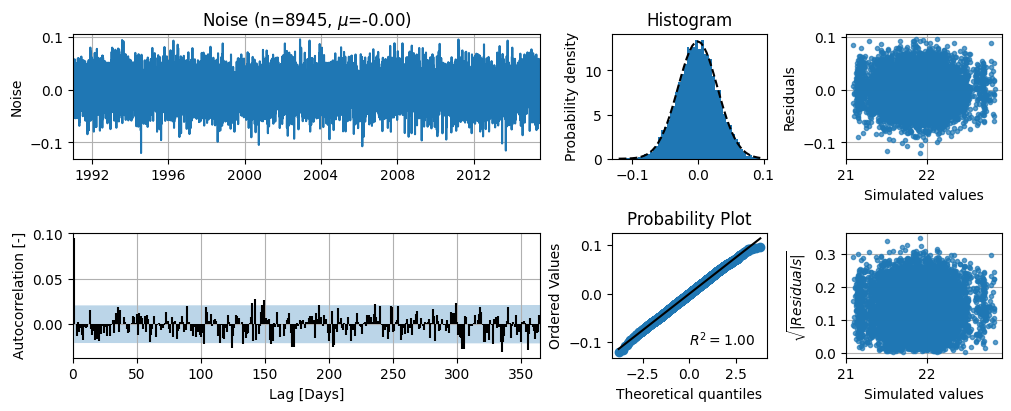

In [9]:
ml.plots.diagnostics(figsize=(10, 4));

Significant autocorrelation is still present at lag 1 and the parameter of the AR(1) is overestimated, trying to correct for the lack of an MA(1) part. This is to be expected, as the MA(1) process generates a strong autocorrelation at this first time lag. The negative autocorrelation in the first few time steps is a result of the overestimation of the AR(1) parameter.

A possible effect of failing to remove the autocorrelation at lag 1 may be that the parameter standard errors are under- or overestimated. Although that does not seem the case for this synthetic, real life examples may suffer from this.

## 8. Test the ARMA NoiseModel for irregular time steps
In this final step the ARMA NoiseModel is tested for irregular timesteps, using the indices from a real groundwater level time series. It is clear from the example below that the ARMA NoiseModel does not yet work for irregular time steps, as (unlike the AR(1) model in Pastas) no weights are applied yet.

In [10]:
index = (
    pd.read_csv("../examples/data/test_index.csv", parse_dates=True, index_col=0)
    .index.round("D")
    .drop_duplicates()
)
head_irregular = head_noise.reindex(index)

0.95 vs 0.95
0.08 vs. 0.1


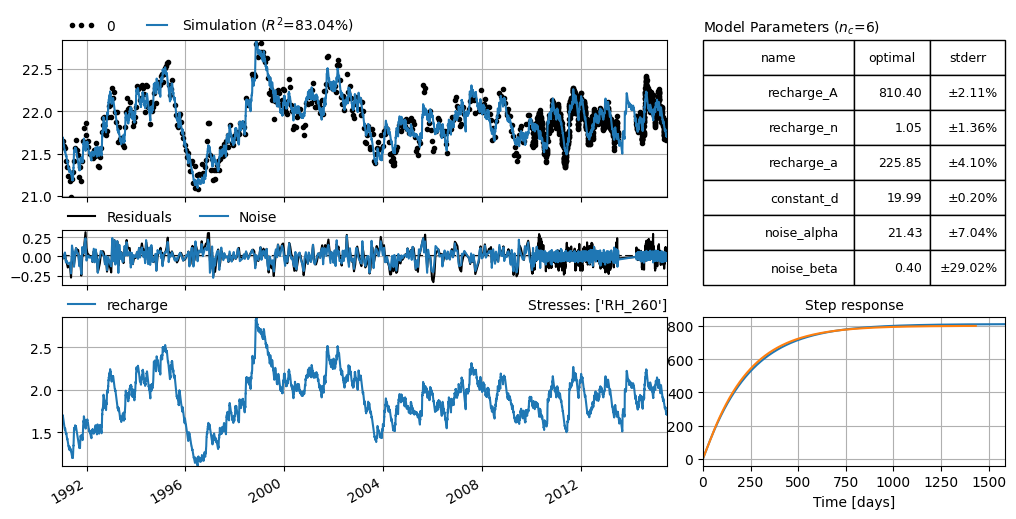

In [11]:
ml = ps.Model(head_irregular)
ml.add_noisemodel(ps.ArNoiseModel())
sm = ps.StressModel(rain, ps.Gamma(), name="recharge", settings="prec")
ml.add_stressmodel(sm)
ml.add_noisemodel(ps.ArmaNoiseModel())

ml.solve(tmin="1991", tmax="2015-06-29", report=False)
axes = ml.plots.results(figsize=(10, 5))
axes[-2].plot(ps.Gamma().step([Atrue, ntrue, atrue]))

print(np.exp(-1.0 / ml.parameters.loc["noise_alpha", "optimal"]).round(2), "vs", alpha)
print(np.exp(-1.0 / ml.parameters.loc["noise_beta", "optimal"]).round(2), "vs.", beta)

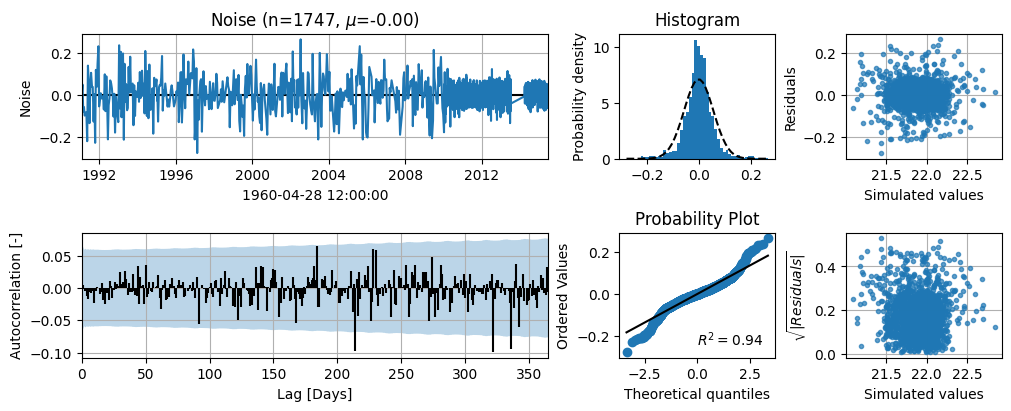

In [12]:
ml.plots.diagnostics(figsize=(10, 4));